In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(601)

from datetime import datetime, timedelta

from tqdm import tqdm_notebook
import time

from haversine import haversine

import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

import gc
gc.collect()

0

# 1. 데이터 Load

In [2]:
train = pd.read_csv('data/train.csv', parse_dates=['pickup_datetime','dropoff_datetime'])
test = pd.read_csv('data/test.csv', parse_dates=['pickup_datetime'])
sample_submission = pd.read_csv('data/sample_submission.csv')

In [3]:
#Only keep trips that lasted less than 5900 seconds
train = train[(train.trip_duration < 5900)]

In [4]:
#Only keep trips with passengers
train = train[(train.passenger_count > 0)]

In [5]:
#Remove position outliers
train = train[(train.pickup_longitude > -100)]
train = train[(train.pickup_latitude < 50)]
#train = train[(train.dropoff_longitude < -70) & (train.dropoff_longitude > -80)]
#train = train[(train.dropoff_latitude < 50)]

In [6]:
train['trip_duration'] = np.log(train['trip_duration'].values)

In [7]:
#One-hot encoding binary categorical features
train = pd.concat([train, pd.get_dummies(train['store_and_fwd_flag'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['store_and_fwd_flag'])], axis=1)

#train.drop(['store_and_fwd_flag'], axis=1, inplace=True)

train = pd.concat([train, pd.get_dummies(train['vendor_id'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['vendor_id'])], axis=1)

#train.drop(['vendor_id'], axis=1, inplace=True)

In [8]:
#Datetyping the dates
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

# train.drop(['dropoff_datetime'], axis=1, inplace=True) #as we don't have this feature in the testset

#Date features creations and deletions
train['month'] = train.pickup_datetime.dt.month
train['week'] = train.pickup_datetime.dt.week
train['weekday'] = train.pickup_datetime.dt.weekday
train['hour'] = train.pickup_datetime.dt.hour
train['minute'] = train.pickup_datetime.dt.minute
train['minute_oftheday'] = train['hour'] * 60 + train['minute']
train.drop(['minute'], axis=1, inplace=True)

test['month'] = test.pickup_datetime.dt.month
test['week'] = test.pickup_datetime.dt.week
test['weekday'] = test.pickup_datetime.dt.weekday
test['hour'] = test.pickup_datetime.dt.hour
test['minute'] = test.pickup_datetime.dt.minute
test['minute_oftheday'] = test['hour'] * 60 + test['minute']
test.drop(['minute'], axis=1, inplace=True)

#train.drop(['pickup_datetime'], axis=1, inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455954 entries, 0 to 1458643
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1455954 non-null  object        
 1   vendor_id           1455954 non-null  int64         
 2   pickup_datetime     1455954 non-null  datetime64[ns]
 3   dropoff_datetime    1455954 non-null  datetime64[ns]
 4   passenger_count     1455954 non-null  int64         
 5   pickup_longitude    1455954 non-null  float64       
 6   pickup_latitude     1455954 non-null  float64       
 7   dropoff_longitude   1455954 non-null  float64       
 8   dropoff_latitude    1455954 non-null  float64       
 9   store_and_fwd_flag  1455954 non-null  object        
 10  trip_duration       1455954 non-null  float64       
 11  N                   1455954 non-null  uint8         
 12  Y                   1455954 non-null  uint8         
 13  1           

In [9]:
#Function aiming at calculating distances from coordinates
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

#Add distance feature
train['distance'] = ft_haversine_distance(train['pickup_latitude'].values,
                                                 train['pickup_longitude'].values, 
                                                 train['dropoff_latitude'].values,
                                                 train['dropoff_longitude'].values)
test['distance'] = ft_haversine_distance(test['pickup_latitude'].values, 
                                                test['pickup_longitude'].values, 
                                                test['dropoff_latitude'].values, 
                                                test['dropoff_longitude'].values)

In [10]:
train['distance'] = np.log1p(train['distance'].values)
test['distance'] = np.log1p(test['distance'].values)

In [11]:
#Function aiming at calculating the direction
def ft_degree(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

#Add direction feature
train['direction'] = ft_degree(train['pickup_latitude'].values,
                                train['pickup_longitude'].values,
                                train['dropoff_latitude'].values,
                                train['dropoff_longitude'].values)
test['direction'] = ft_degree(test['pickup_latitude'].values,
                                  test['pickup_longitude'].values, 
                                  test['dropoff_latitude'].values,
                                  test['dropoff_longitude'].values)

In [12]:
#Remove distance outliers
train = train[(train.distance < 200)]

In [13]:
#Create speed feature
train['speed'] = train.distance / train.trip_duration

In [14]:
#Remove speed outliers
train = train[(train.speed < 30)]
train.drop(['speed'], axis=1, inplace=True)

https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm

In [15]:
fr1 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

In [16]:
train_street_info = pd.concat((fr1, fr2))

train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

In [17]:
idx = train[(train.total_distance.isnull()==True)].index
train = train.drop(idx)

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

In [ ]:
with open("train.pkl", "wb") as f:
    pickle.dump(train, f)
    
with open("test.pkl", "wb") as f:
    pickle.dump(test, f)    
"""
with open("train.pkl", "rb") as f:
    train = pickle.load(f)    
    
with open("test.pkl", "rb") as f:
    test = pickle.load(f)        
"""    

In [ ]:
#Correlations between variables
columns = ['passenger_count',  'pickup_longitude',   'pickup_latitude',
       'dropoff_longitude',  'dropoff_latitude',                 'N',
                       'Y',                   1,                   2,
                   'month',              'week',           'weekday',
                    'hour'
       ,   'minute_oftheday'
       ,          'distance',
               'direction'
           
           ,'total_distance',  'total_travel_time','number_of_steps']

corr_df = train[columns]

fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(data=corr_df.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlations between variables');

In [33]:
# Feature Extraction
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

In [34]:
kmeans = MiniBatchKMeans(n_clusters=3, init='k-means++').fit(coords)

In [35]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [36]:
# Feature Extraction
coords = np.vstack((train[['hour','weekday', 'direction']].values,
                    test[['hour','weekday', 'direction']].values
                   ))

In [37]:
kmeans = MiniBatchKMeans(n_clusters=2, init='k-means++').fit(coords)

In [102]:
train.loc[:, 'time_cluster'] = kmeans.predict(train[['hour','weekday', 'direction']])
test.loc[:, 'time_cluster'] = kmeans.predict(test[['hour','weekday', 'direction']])

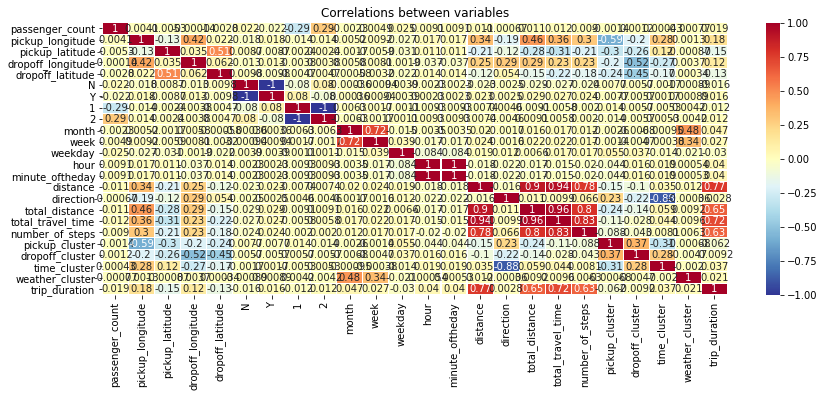

In [87]:
columns = ['passenger_count',  'pickup_longitude',   'pickup_latitude',
       'dropoff_longitude',  'dropoff_latitude',                 'N',
                       'Y',                   1,                   2,
                   'month',              'week',           'weekday',
                    'hour'
       ,   'minute_oftheday'
       ,          'distance',
               'direction'
           
           ,'total_distance',  'total_travel_time','number_of_steps'
           
           ,'pickup_cluster','dropoff_cluster'
          ,'time_cluster'

          ,'trip_duration']

corr_df = train[columns]

#Correlations between variables

fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(data=corr_df.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlations between variables');

In [98]:
train.columns

Index([                 'id',           'vendor_id',     'pickup_datetime',
          'dropoff_datetime',     'passenger_count',    'pickup_longitude',
           'pickup_latitude',   'dropoff_longitude',    'dropoff_latitude',
        'store_and_fwd_flag',       'trip_duration',                   'N',
                         'Y',                     1,                     2,
                     'month',                'week',             'weekday',
                      'hour',     'minute_oftheday',            'distance',
                 'direction',      'total_distance',   'total_travel_time',
           'number_of_steps',                'date',      'pickup_cluster',
           'dropoff_cluster',        'time_cluster', 'maximum temperature',
       'minimum temperature', 'average temperature',       'precipitation',
                 'snow fall',          'snow depth',     'weather_cluster'],
      dtype='object')

In [46]:
import lightgbm as lgb

In [47]:
y = train["trip_duration"]
y.shape

(1455921,)

In [ ]:
train.columns
test.columns

In [114]:
columns = ['passenger_count'
           
           ,  'pickup_longitude',   'pickup_latitude', 'dropoff_longitude',  'dropoff_latitude'
           ,           'N'    ,    'Y',                   1,                   2,
                   'month',              'week',           'weekday',
                    'hour'
       ,   'minute_oftheday'
       ,          'distance'
       , 'direction'
          
          ,'total_distance'
           ,  'total_travel_time'
           ,'number_of_steps'
           
           ,'pickup_cluster','dropoff_cluster'
           
            ,'time_cluster'
           

           
          ]
X = train[columns]
X.shape

(1455921, 24)

In [110]:
#Test the following parameters
lgb_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'objective': 'regression',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 
    ,'num_threads' : -1
    ,'random_state':601}

In [ ]:
%%time
#Training on all labeled data using the best parameters
lgb_df = lgb.Dataset(X, y)
lgb_model = lgb.train(lgb_params, lgb_df, num_boost_round=1000)

In [112]:
#Make predictions on test data frame

#predictions = lgb_model.predict(test[test_columns])
predictions = lgb_model.predict(test[columns])
submission = pd.DataFrame({'id': test.id, 'trip_duration': np.expm1(predictions)})
submission.to_csv("./output/20200828-15.csv", index=False)

In [113]:
gc.collect()

151

In [ ]:
"""
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 601)
oof = np.zeros(X.shape[0])
test_pred = np.zeros(y.shape[0])
feature_importance_df = pd.DataFrame()

for _fold, (train_index, eval_index) in enumerate(folds.split(X, X['bin_target'])):
    print(f"\nFold: {_fold} \n-------------------------")
    x_train = X.iloc[train_index][features].values ; y_train = target.iloc[train_index]
    x_eval = X.iloc[eval_index][features].values ; y_eval = target.iloc[eval_index]
            
    train_data = lgbm.Dataset(x_train, y_train)
    eval_data = lgbm.Dataset(x_eval, y_eval)

    model = lgbm.train(params, train_data, num_boost_round=1500, valid_sets= (train_data, eval_data),
                early_stopping_rounds=100, verbose_eval=100)
    
    eval_pred = model.predict(X.iloc[eval_index][features], num_iteration = model.best_iteration)

    oof[eval_index] = eval_pred
    
    test_pred += (np.exp(model.predict(y[features], num_iteration = model.best_iteration)) - 1) / folds.n_splits 
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Features'] = features
    fold_importance_df['Importance'] = model.feature_importance()
    feature_importance_df = pd.concat((feature_importance_df, fold_importance_df), axis = 0)
"""

위치/기간  클러스터 조정하기

판다스 프로파일링 

https://www.kaggle.com/jeffreycbw/nyc-taxi-trip-public-0-37399-private-0-37206

https://www.kaggle.com/selfishgene/historical-hourly-weather-data/discussion